In [1]:
import os
import glob

files = glob.glob(os.path.join('res', 'data', 'MapData-Export', '*.json'))

print(files)

['res/data/MapData-Export/AllActors.json', 'res/data/MapData-Export/DropPods.json', 'res/data/MapData-Export/ResourceNodes.json']


In [2]:
import json

resources = None
with open(files[2], 'r') as resources_file:
    resources = json.load(resources_file)

for key in resources.keys():
    print(key, len(resources[key]))

nodes 412
geysers 18
frackingCores 16
frackingSatellites 112


In [3]:
# Transform all values into the format specified below
# name purity x y z
nodes_list = []
for node in resources['nodes'] : 
    res = {}
    res['name'] = node['item']['name'].lower().replace(' ', '-')
    res['purity'] = node['purity'][3:]
    res.update(node['location'])
    nodes_list.append(res)

for core in resources['frackingCores']:
    res = {}
    res['name'] = core['item']['name'].lower().replace(' ', '-')
    res['purity'] = None
    res.update(core['location'])
    nodes_list.append(res)

for geyser in resources['geysers']:
    res = {}
    res['name'] = geyser['item']['name'].lower().replace(' ', '-')
    res['purity'] = geyser['purity'][3:]
    res.update(geyser['location'])
    nodes_list.append(res)

for satellite in resources['frackingSatellites'] : 
    res = {}
    res['name'] = satellite['item']['name'].lower().replace(' ', '-') + '-satellite'
    res['purity'] = satellite['purity'][3:]
    res.update(satellite['location'])
    nodes_list.append(res)

import pandas

nodes_df = pandas.DataFrame(nodes_list)
del nodes_list

nodes_df

name  purity              x              y  \
0                 crude-oil  Normal  178265.375000  206095.640625   
1                   sam-ore  Normal  181999.062500  114342.000000   
2                 limestone  Normal -280836.687500  -42089.179688   
3                 limestone  Normal -267051.406250  -24386.789062   
4                 limestone  Normal -273321.218750  -19667.000000   
..                      ...     ...            ...            ...   
553         water-satellite    Pure    7164.156250  183858.437500   
554         water-satellite    Pure    5973.214844  189394.375000   
555         water-satellite    Pure    9112.531250  184869.937500   
556         water-satellite    Pure   10342.593750  187520.593750   
557  nitrogen-gas-satellite    Pure  128216.000000  258878.000000   

                z  
0    -9238.571289  
1    10285.468750  
2    -1276.147949  
3     -723.648499  
4    -1537.054688  
..            ...  
553 -10524.945312  
554 -10357.742188  
555 -10505.742188  
556 -10473.582031  
557    890.000000  

[558 rows x 5 columns]

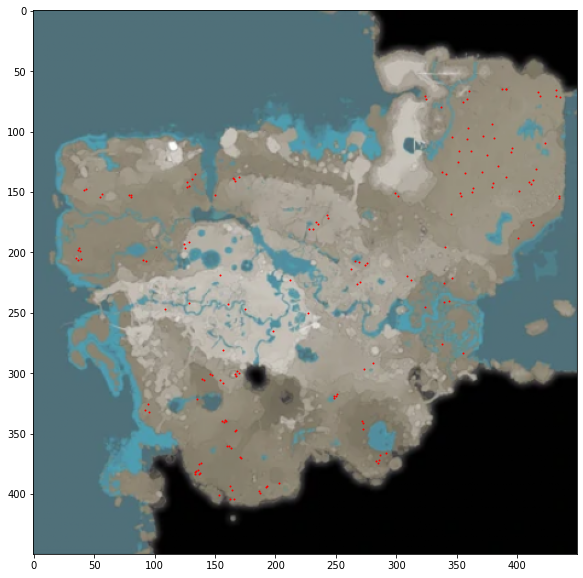

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import resize
def show_on_map(df, x='x', y='y', z='z', x_adjust = 1670, y_adjust = 1670, min_x = None, min_y = None,
                s=1, segment_key = None, cmap='viridis', figsize = [10, 10]):
    ''' Show points from a dataframe's x and y columns on map.
    We make use of adjustment factors, that have been manually adjusted, to scale on a background image of
    the actual in-game map.
    
    This helps us find the nodes quite easily and accurately. As well as show analyzed data points on the map.
    @author Supratik Chatterjee
    '''
    global nodes_df
    if min_x is None:
        min_x = nodes_df['x'].min()
    if min_y is None:
        min_y = nodes_df['y'].min()
    c_df = df.copy()
    c_df[x] = c_df[x].transform(lambda x : ((x - min_x) / x_adjust) + 24)
    c_df[y] = c_df[y].transform(lambda x : ((x - min_y) / y_adjust) + 35)
    # display plots
    plt.rcParams['figure.figsize'] = figsize
    im = plt.imread(os.path.join("res", "images", "Map.webp"))
    im = resize(im, (450, 450))
    if segment_key is None:
        plt.scatter(x=c_df[x], y=c_df[y], s=s, c='r')
    else:
        colors = matplotlib.cm.get_cmap(cmap)
        ctr = 1
        fig, ax = plt.subplots()
        entries = df[segment_key].unique()
        for entry in entries:
            p_df = c_df[c_df[segment_key] == entry]
            ax.scatter(p_df[x], p_df[y], color = [colors(ctr / len(entries))], label = entry, s = s)
            ctr += 1
        ax.legend(loc=4)
    implot = plt.imshow(im)
    plt.show()

# Example 1
show_on_map(nodes_df[nodes_df['name'].isin(['coal', 'iron-ore'])])

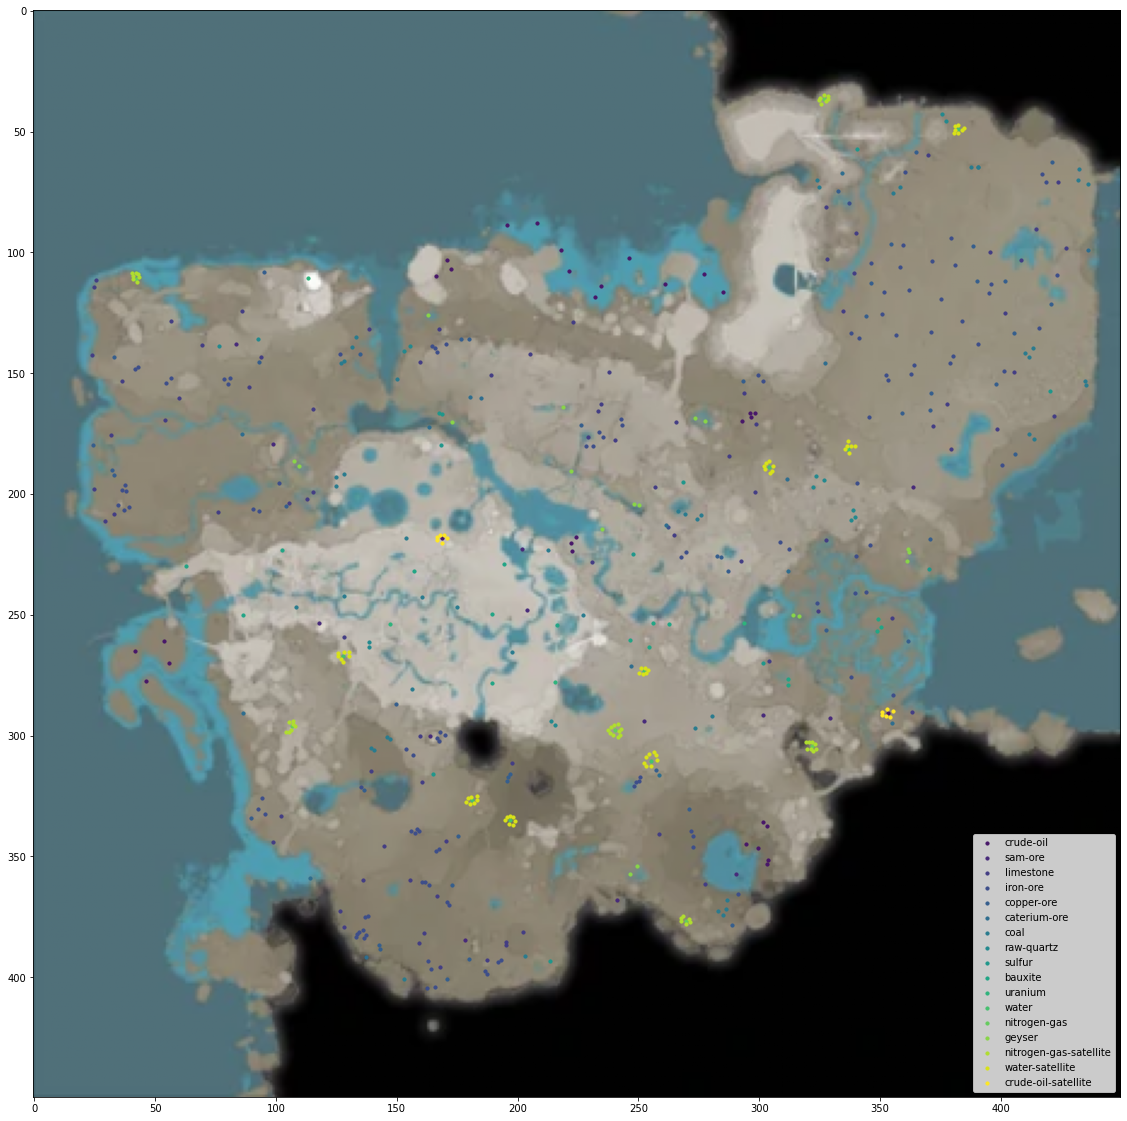

In [5]:
# Example 2
show_on_map(nodes_df, segment_key='name', figsize = [20, 20], s=10)

## Extraction and storage of materials

Our focus is on complete utilization of resources.
Every resource produced in the most efficient way possible.

We find the locations using the **quality** of the node as a heuristic.

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_kmeans(df, kmax = 12, debug = False, label = 'Unlabelled'):
    res = None
    c_max = 0
    c_ind = 0
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1 if kmax < len(df) else len(df)):
        kmeans = KMeans(n_clusters = k).fit(df)
        labels = kmeans.labels_
        sil_score = silhouette_score(df, labels, metric = 'euclidean')
        if debug:
            print('k : ', k, ', silhoutte score : ', sil_score)
        if c_max < sil_score : 
            c_max = sil_score
            res = kmeans
    return res

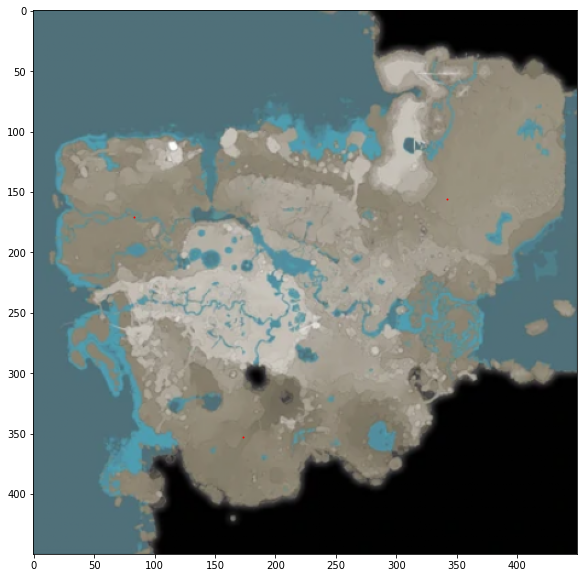

In [7]:
def get_cluster_points(resources, max_count=12, label=None):
    global nodes_df
    p_df = nodes_df[nodes_df['name'].isin(resources)]
    def apply_bias(x):
        if x['purity'] == 'Inpure':
            # print('Inpure')
            x['x'] *= 0.25
            x['y'] *= 0.25
        if x['purity'] == 'Normal':
            # print('Normal')
            x['x'] *= 0.5
            x['y'] *= 0.5
        if x['purity'] == 'Pure':
            # print('Pure')
            x['x'] *= 1
            x['y'] *= 1
        return x
    # p_df = p_df.transform(apply_bias, axis=1)
    res_df = p_df[['x', 'y', 'z']]
    del p_df
    if len(res_df) == 0:
        raise Exception("No resources found for list : ", resources)
    kmeans = get_kmeans(res_df, kmax=max_count)
    del res_df
    res_df = pandas.DataFrame(kmeans.cluster_centers_, columns=['x', 'y', 'z'])
    res_df['label'] = label
    del kmeans
    return res_df

# Example
show_on_map(get_cluster_points(['iron-ore'], label = 'iron-clusters'))

In [8]:
# example 2
clusters = None
for resource in ['Iron Ore', 'Coal', 'Bauxite', 'Copper Ore', 'Crude Oil', 'Limestone', 'Uranium', 'Caterium Ore', 'Sulfur', 'Raw Quartz']:
    df = get_cluster_points([resource.lower().replace(' ','-')], label=resource.lower().replace(' ', '-') + '-cluster', max_count = 8)
    print(resource, len(df))
    if clusters is None:
        clusters = df
    else:
        clusters = clusters.append(df, ignore_index=True)
del df

Iron Ore 3
Coal 2
Bauxite 5
Copper Ore 3
Crude Oil 8
Limestone 3
Uranium 2
Caterium Ore 4
Sulfur 4
Raw Quartz 6


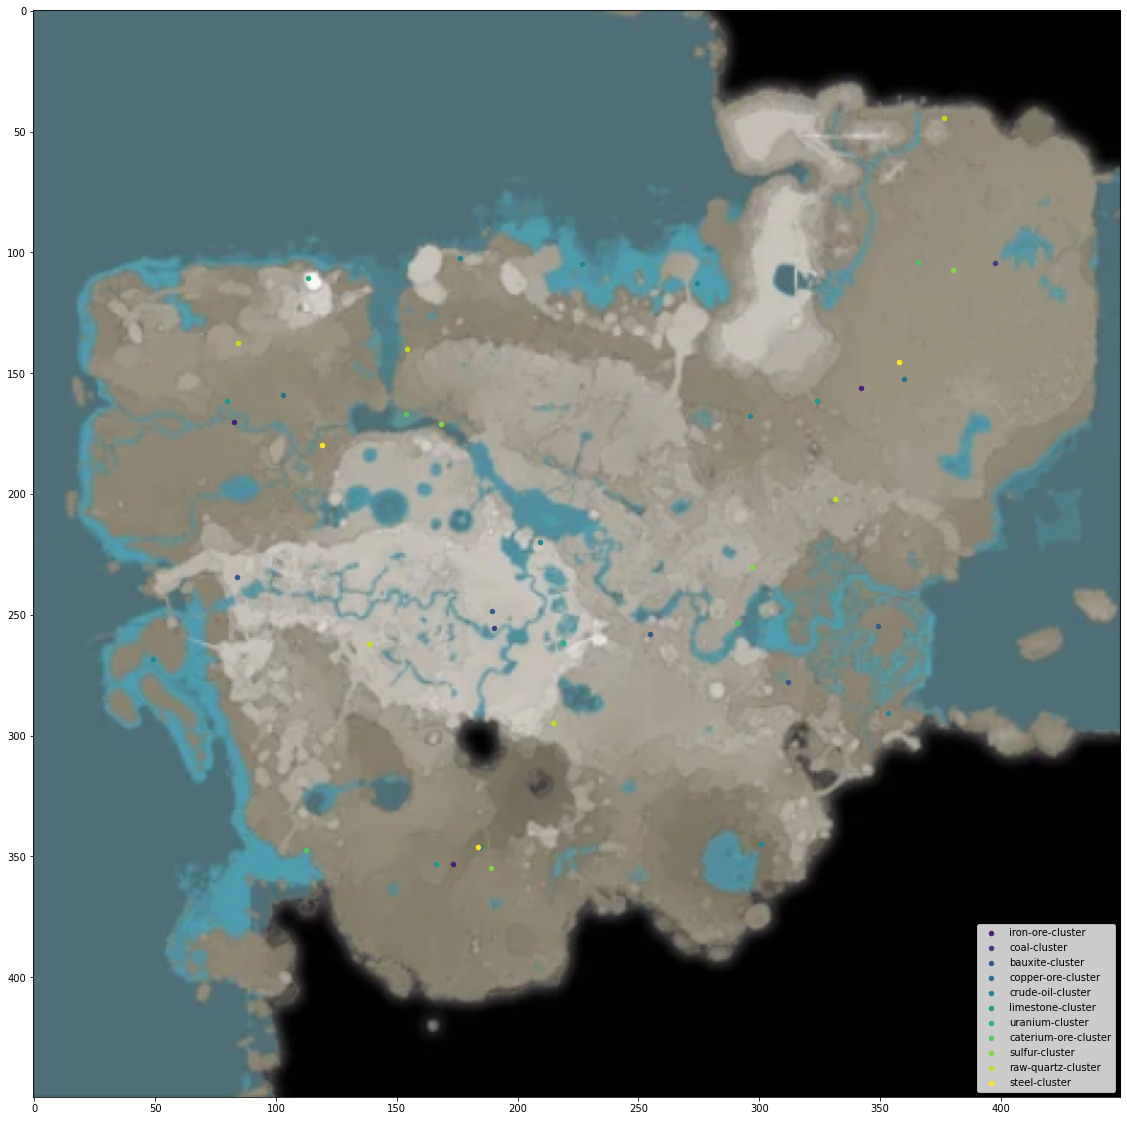

In [9]:
# Composites

# Steel
df = get_cluster_points(['coal', 'iron-ore'], label = 'steel-cluster', max_count = 8)
clusters = clusters.append(df, ignore_index=True)
show_on_map(clusters, s=20, figsize=[20, 20], segment_key='label')

In [10]:
# show_on_map(clusters[clusters['label'] == 'iron-ore-cluster'])

In [11]:
# kmeans = get_kmeans(clusters[['x', 'y', 'z']])
# res_df = pandas.DataFrame(kmeans.cluster_centers_, columns=['x', 'y', 'z'])
# res_df['label'] = "Hyper Factories"
# show_on_map(res_df, s=50)

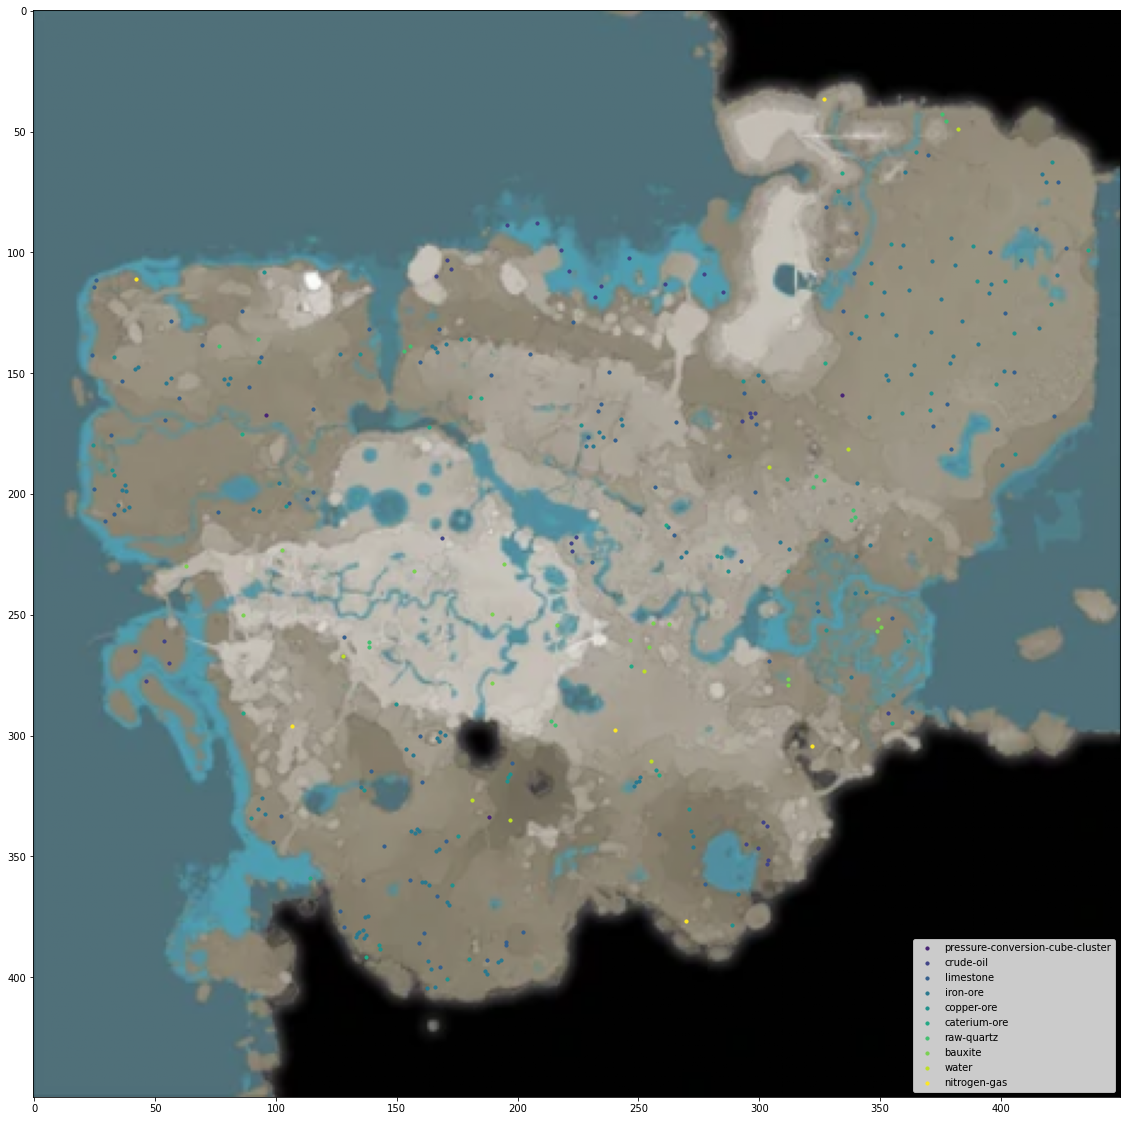

In [26]:
materials = ['bauxite', 'caterium-ore', 'copper-ore', 'iron-ore', 'limestone', 'raw-quartz', 'crude-oil', 'nitrogen-gas', 'water']
res_df = get_cluster_points(materials, label='pressure-conversion-cube-cluster', max_count= 8)
matter_nodes = nodes_df[nodes_df['name'].isin(materials)]
matter_nodes = matter_nodes.rename(columns={'name':'label'})
res_df = res_df.append(matter_nodes)
show_on_map(res_df, segment_key='label', figsize = [20, 20], s=10)
# nodes_df[nodes_df['name'].isin(materials)]
# res_df

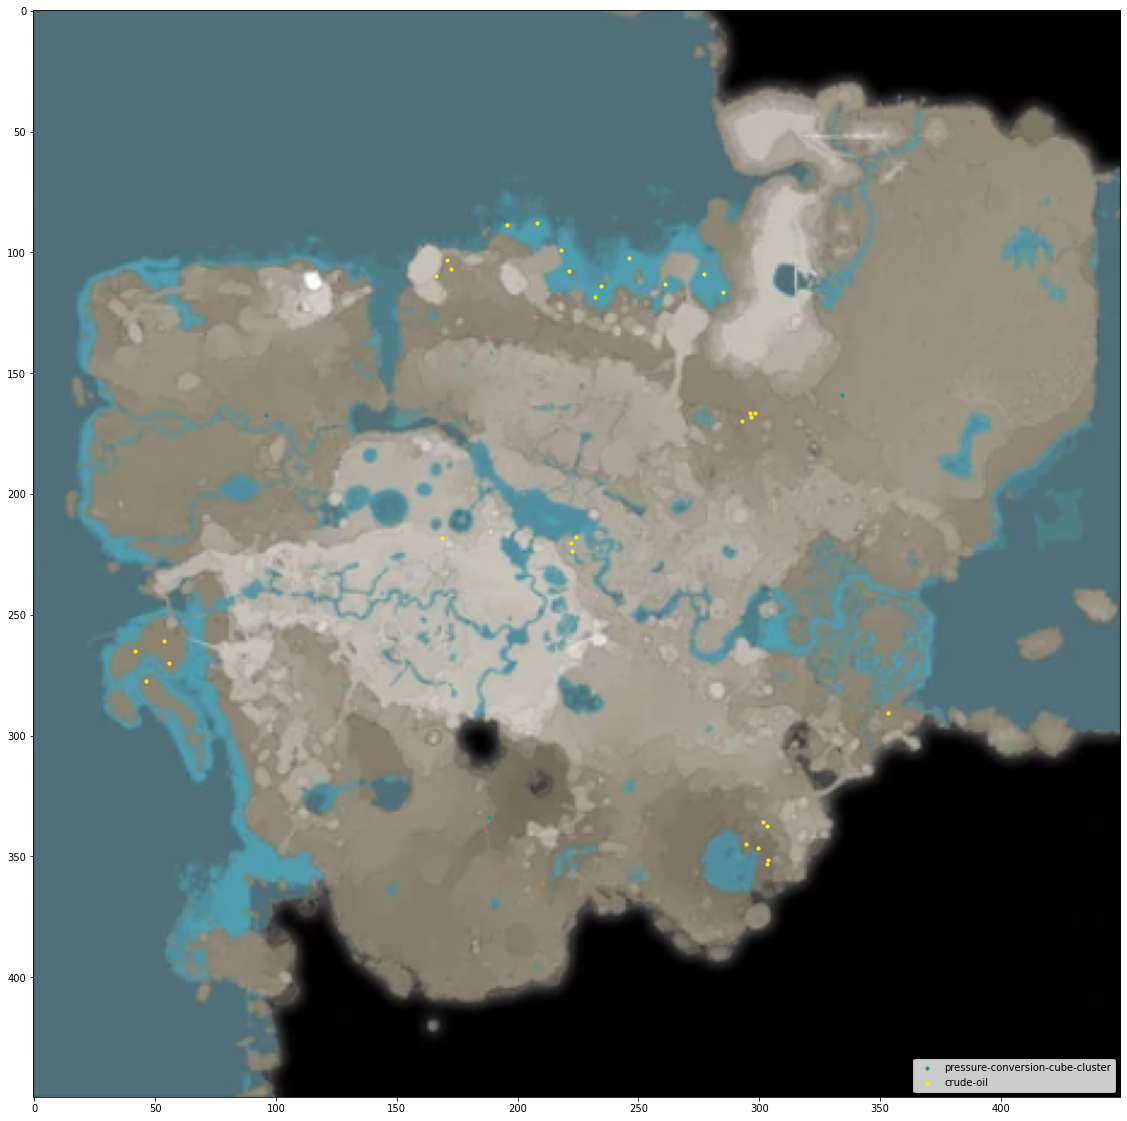

In [28]:
show_on_map(res_df[res_df['label'].isin(['crude-oil', 'pressure-conversion-cube-cluster'])], segment_key='label', figsize = [20, 20], s=10)